# Exploratory Data Analysis on PWM Behavioral Data

**Goal** This notebook will explore the new dataset to see what trends are present now that violations are properly tracked and timeouts are not incorrectly marked as violations.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd

from multiglm.data.dataset_loader import *
from multiglm.data import ANIMAL_IDS

sns.set_context("talk")

%load_ext autoreload
%autoreload 2

choice_palette = sns.color_palette("Set2", 3)

## Load In

Deciding to not include W082 in analyses- this animal violates on over 50% of trials (over double the 16 other animals), and is an extreme outlier for these visualizations and analyses. This animal will be removed from modeling analyses as well.

In [3]:
full_df = (
    DatasetLoader(
        animal_ids=ANIMAL_IDS,
        data_type="new_all",
    )
    .load_data()
    .query("animal_id != 'W082'")
    .copy()
)
trained_df = (
    DatasetLoader(
        animal_ids=ANIMAL_IDS,
        data_type="new_trained",
    )
    .load_data()
    .query("animal_id != 'W082'")
    .copy()
)

Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']
Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']


## Sessions

In [4]:
trial_counts = (
    full_df.groupby(["training_stage", "animal_id"]).size().reset_index(name="count")
)

merged_counts = pd.merge(
    full_df.groupby(["animal_id", "training_stage"])["session"].nunique().reset_index(),
    trial_counts,
    on=["animal_id", "training_stage"],
)

merged_counts = pd.merge(
    full_df.groupby(["training_stage", "animal_id", "session"])
    .trial.max()
    .reset_index()
    .groupby(["training_stage", "animal_id"])
    .trial.mean()
    .reset_index(),
    merged_counts,
    on=["animal_id", "training_stage"],
)

merged_counts.head()

,training_stage,animal_id,trial,session,count
0,1,W051,244.157895,19,4639
1,1,W060,228.062500,32,7298
2,1,W065,228.105263,19,4334
3,1,W066,221.294118,17,3762
4,1,W068,207.842105,19,3949


Text(0.5, 1.0, 'N trials per Session')

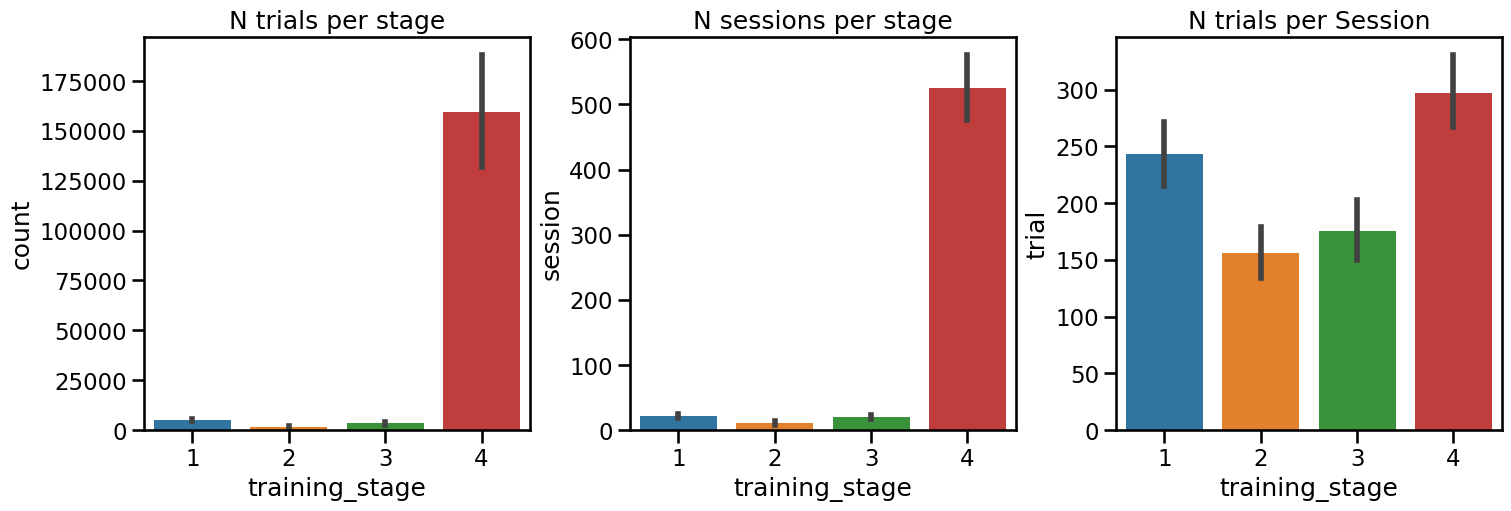

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)


sns.barplot(merged_counts, x="training_stage", y="count", ax=ax[0])
ax[0].set_title("N trials per stage")


sns.barplot(data=merged_counts, x="training_stage", y="session", ax=ax[1])
ax[1].set_title("N sessions per stage")

sns.barplot(data=merged_counts, x="training_stage", y="trial", ax=ax[2])
ax[2].set_title("N trials per Session")

### Trained DF Stats

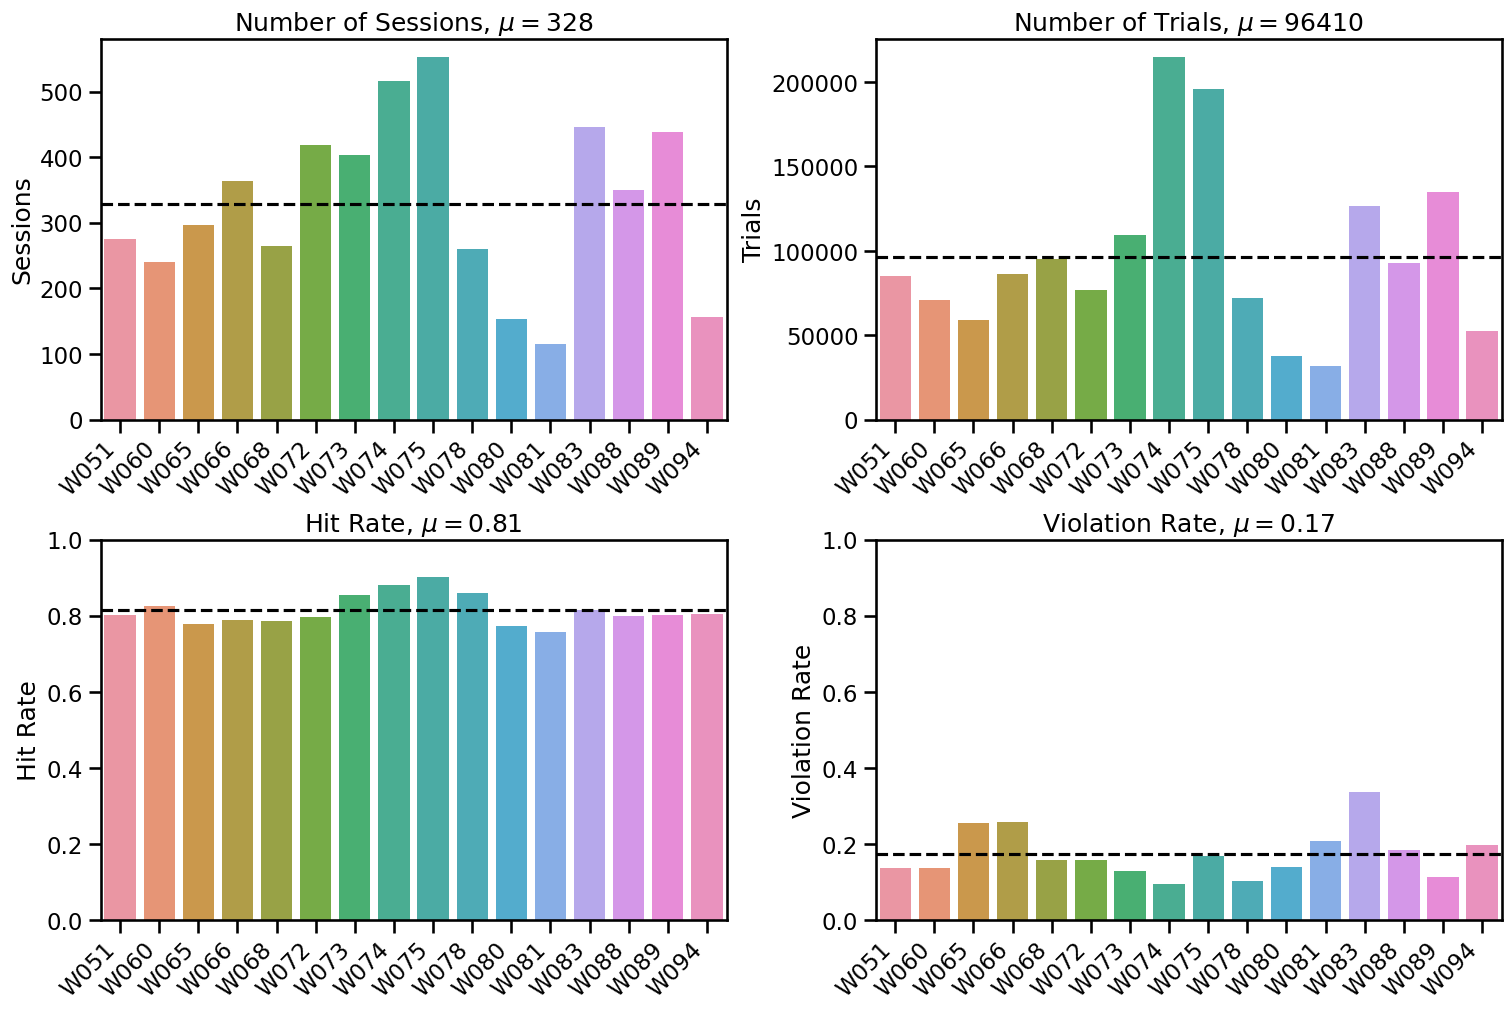

In [6]:
trained_df_count_stats = pd.read_csv(
    "../data/processed/dataset_thresholding/trained_threshold_df_stats.csv"
).query("animal_id != 'W082'")

fig, ax = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)


plot_df = trained_df_count_stats

sns.barplot(x="animal_id", y="n_sessions", data=plot_df, ax=ax[0, 0])
session_mean = plot_df.n_sessions.mean()
ax[0, 0].axhline(session_mean, color="k", linestyle="--")
_ = ax[0, 0].set(
    title=f"Number of Sessions, $\mu = ${session_mean:.0f}",
    xlabel="",
    ylabel="Sessions",
)

sns.barplot(x="animal_id", y="n_trials", data=plot_df, ax=ax[0, 1])
trials_mean = plot_df.n_trials.mean()
ax[0, 1].axhline(trials_mean, color="k", linestyle="--")
_ = ax[0, 1].set(
    title=f"Number of Trials, $\mu= ${trials_mean:.0f}", xlabel="", ylabel="Trials"
)


sns.barplot(x="animal_id", y="avg_hit", data=plot_df, ax=ax[1, 0])
hit_mean = plot_df.avg_hit.mean()
ax[1, 0].axhline(hit_mean, color="k", linestyle="--")
_ = ax[1, 0].set(
    title=f"Hit Rate, $\mu = ${hit_mean:.2f}", xlabel="", ylabel="Hit Rate", ylim=(0, 1)
)

sns.barplot(x="animal_id", y="avg_violation", data=plot_df, ax=ax[1, 1])
violation_mean = plot_df.avg_violation.mean()
ax[1, 1].axhline(violation_mean, color="k", linestyle="--")
_ = ax[1, 1].set(
    title=f"Violation Rate, $\mu = ${violation_mean:.2f}",
    xlabel="",
    ylabel="Violation Rate",
    ylim=(0, 1),
)

for a in ax.flatten():
    _ = a.set_xticklabels(a.get_xticklabels(), rotation=45, ha="right")

## Hit Rates


In [7]:
session_hit_by_stage = (
    full_df.groupby(["animal_id", "training_stage", "session"])
    .hit.mean()
    .reset_index()
    .groupby(["animal_id", "training_stage"])
    .hit.mean()
    .reset_index()
)
session_hit_by_stage.head()

,animal_id,training_stage,hit
0,W051,1,0.973147
1,W051,2,0.995332
2,W051,3,0.517187
3,W051,4,0.739582
4,W060,1,0.938054


[Text(0.5, 1.0, 'Hit Rate by Stage'),
 Text(0.5, 0, 'Training Stage'),
 Text(0, 0.5, 'Session Avg. Hit Rate'),
 (0.0, 1.0)]

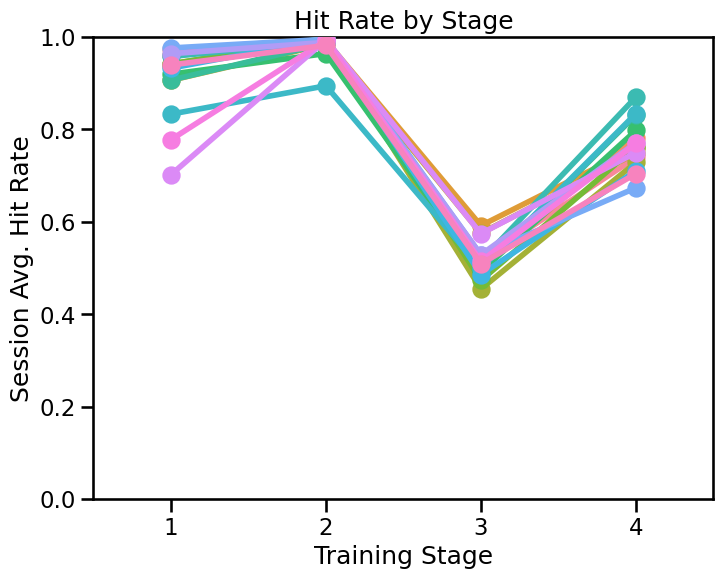

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(
    x="training_stage", y="hit", hue="animal_id", data=session_hit_by_stage, ax=ax
)
ax.legend_.remove()

ax.set(
    title="Hit Rate by Stage",
    xlabel="Training Stage",
    ylabel="Session Avg. Hit Rate",
    ylim=(0, 1),
)

Hit rates are high in stage 1 and 2 due to light guidance, plummet in stage 3 and then climb back to final performance in stage 4.

## Violation Rates

- over stages by animal (save data out)

In [9]:
session_violation_by_stage = (
    full_df.groupby(["animal_id", "training_stage", "session"])
    .violation.mean()
    .reset_index()
    .groupby(["animal_id", "training_stage"])
    .violation.mean()
    .reset_index()
)
session_violation_by_stage.head()

,animal_id,training_stage,violation
0,W051,1,0.193562
1,W051,2,0.173270
2,W051,3,0.273946
3,W051,4,0.154241
4,W060,1,0.257598


[Text(0.5, 1.0, 'Violation Rate by Stage'),
 Text(0.5, 0, 'Training Stage'),
 Text(0, 0.5, 'Session Avg. Violation Rate'),
 (0.0, 1.0)]

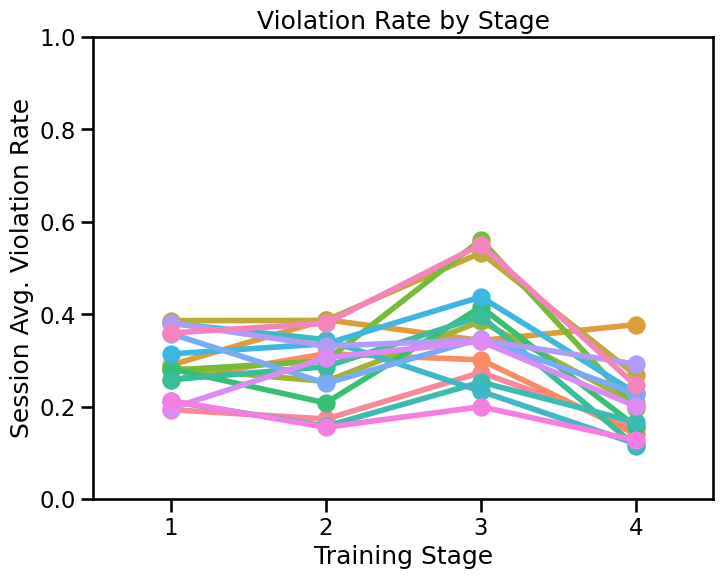

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(
    x="training_stage",
    y="violation",
    hue="animal_id",
    data=session_violation_by_stage,
    ax=ax,
)
ax.legend_.remove()

ax.set(
    title="Violation Rate by Stage",
    xlabel="Training Stage",
    ylabel="Session Avg. Violation Rate",
    ylim=(0, 1),
)

Over time, violation rates drop. Interestingly, they do appear to rise in stage 3 when the hit rates also drop. Perhaps violations are more likely during learning due to frustration/decreased motivation.

## Hit & Violation

### By Stage

In [11]:
hit_viols_by_stage = pd.merge(
    session_hit_by_stage, session_violation_by_stage, on=["animal_id", "training_stage"]
)

hit_viols_by_stage.to_csv(
    "../data/processed/from_eda/01_session_avg_hit_viols_by_stage.csv", index=False
)

hit_viols_by_stage.head()

,animal_id,training_stage,hit,violation
0,W051,1,0.973147,0.193562
1,W051,2,0.995332,0.173270
2,W051,3,0.517187,0.273946
3,W051,4,0.739582,0.154241
4,W060,1,0.938054,0.257598


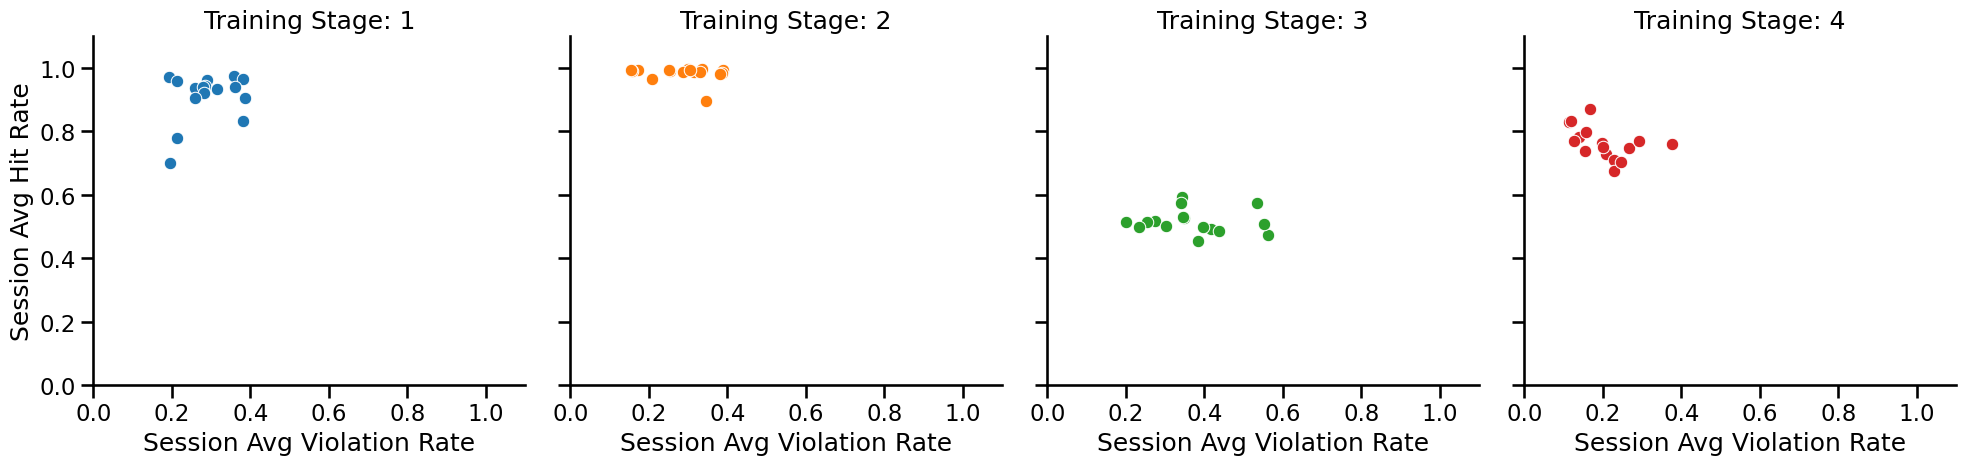

In [12]:
g = sns.FacetGrid(
    data=hit_viols_by_stage,
    col="training_stage",
    hue="training_stage",
    sharey=True,
    sharex=True,
    height=5,
    aspect=1,
    xlim=(0, 1.1),
    ylim=(0, 1.1),
)
g.map(sns.scatterplot, "violation", "hit")

g.set_axis_labels(x_var="Session Avg Violation Rate", y_var="Session Avg Hit Rate")
g.set_titles("Training Stage: {col_name}")

Stage 1, 2 and 4 do not appear to have a correlation between violation rate and hit rates. Stage 3 does appear to, but this seems to be largely driven by the outlier with violation rates > 0.8.

### Trained Data

In [13]:
trained_hit_viol_rates = (
    trained_df.groupby(["animal_id", "session"])
    .agg({"hit": "mean", "violation": "mean"})
    .reset_index()
    .groupby(["animal_id"])
    .agg({"hit": "mean", "violation": "mean"})
    .rename(columns={"hit": "trained_hit", "violation": "trained_violation"})
    .reset_index()
)


trained_hit_viol_rates.to_csv(
    "../data/processed/from_eda/01_trained_session_avg_hit_viol_rates.csv", index=False
)

trained_hit_viol_rates.head()

,animal_id,trained_hit,trained_violation
0,W051,0.796836,0.154370
1,W060,0.825368,0.149891
2,W065,0.775634,0.260626
3,W066,0.788768,0.253332
4,W068,0.778252,0.163857


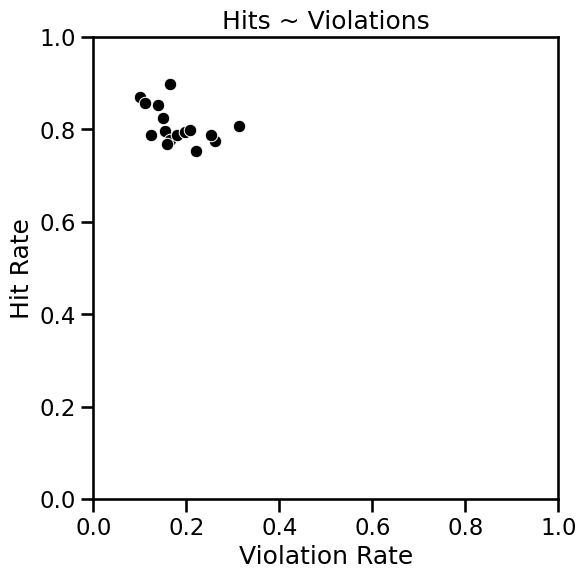

In [14]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    data=trained_hit_viol_rates,
    y="trained_hit",
    x="trained_violation",
    color="k",
    ax=ax,
)

_ = ax.set(
    ylabel="Hit Rate",
    xlabel="Violation Rate",
    title="Hits ~ Violations",
    ylim=(0, 1),
    xlim=(0, 1),
)

There does not appear to be a strong relationship between violation rate and hit rate

### Stage Perf Predicting Final Hit Rate

In [15]:
hit_viol_training_and_trained = pd.merge(
    hit_viols_by_stage, trained_hit_viol_rates, how="left", on="animal_id"
)

hit_viol_training_and_trained.head()

,animal_id,training_stage,hit,violation,trained_hit,trained_violation
0,W051,1,0.973147,0.193562,0.796836,0.154370
1,W051,2,0.995332,0.173270,0.796836,0.154370
2,W051,3,0.517187,0.273946,0.796836,0.154370
3,W051,4,0.739582,0.154241,0.796836,0.154370
4,W060,1,0.938054,0.257598,0.825368,0.149891


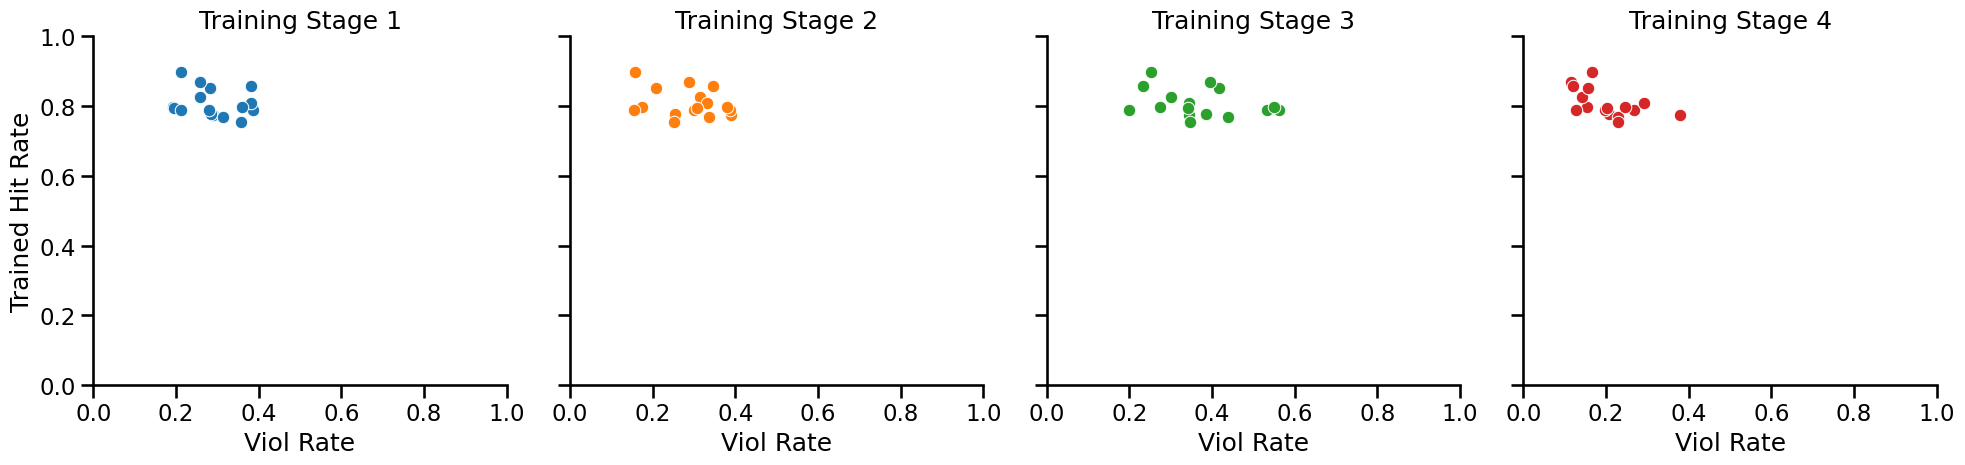

In [16]:
g = sns.FacetGrid(
    data=hit_viol_training_and_trained,
    col="training_stage",
    hue="training_stage",
    sharey=True,
    sharex=True,
    height=5,
    aspect=1,
    xlim=(0, 1),
    ylim=(0, 1),
)
g.map(sns.scatterplot, "violation", "trained_hit")

g.set_axis_labels(x_var="Viol Rate", y_var="Trained Hit Rate")
g.set_titles("Training Stage {col_name}")

### Post Violation Hit Rate

In [17]:
# Step 1: Add Prev Violation Column
def calculate_prev_violation(group):
    session_boundaries_mask = group["session"].diff() == 0
    group["prev_violation"] = (
        group["violation"].shift() * session_boundaries_mask
    ).fillna(0)
    return group


trained_df = (
    trained_df.groupby("animal_id")
    .apply(calculate_prev_violation)
    .reset_index(drop=True)
)

In [18]:
# Step 2: Calculate Hit Rate Post Violation or not
viol_hit_rates = (
    trained_df.groupby(["animal_id", "session", "prev_violation"])
    .hit.mean()
    .reset_index()
    .groupby(["animal_id", "prev_violation"])
    .hit.mean()
    .reset_index()
    .rename({"hit": "hit_rate"}, axis=1)
)

In [19]:
# Step 3: Turn long form -> Wide Form to plot each column
wide_hit_rates = viol_hit_rates.pivot(
    index="animal_id", columns="prev_violation", values="hit_rate"
)

wide_hit_rates.columns = ["hit_rate_no_prev_viol", "hit_rate_with_prev_viol"]

wide_hit_rates.reset_index(inplace=True)

wide_hit_rates.to_csv(
    "../data/processed/from_eda/01_post_viol_hit_rates.csv", index=False
)
wide_hit_rates.head()

,animal_id,hit_rate_no_prev_viol,hit_rate_with_prev_viol
0,W051,0.803490,0.764054
1,W060,0.830631,0.783092
2,W065,0.776971,0.767371
3,W066,0.787902,0.792920
4,W068,0.779370,0.771608


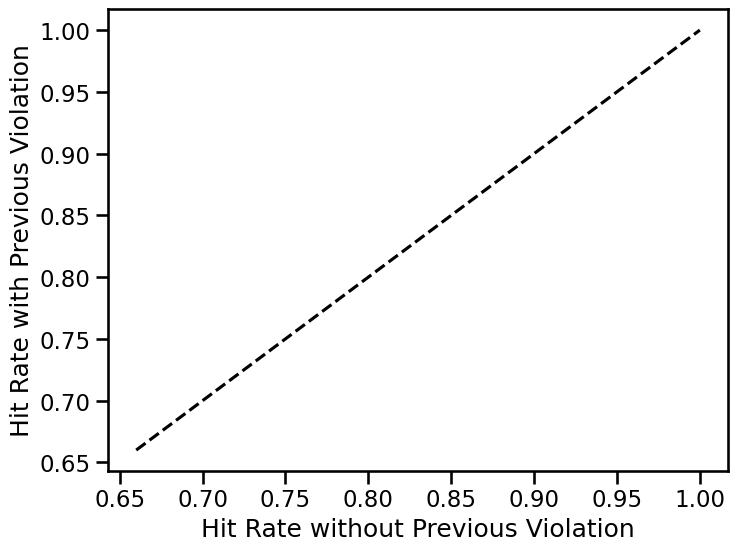

In [22]:
limits = (0.66, 1)
# Scatter plot
plt.figure(figsize=(8, 6))
# sns.scatterplot(
#     data=wide_hit_rates, x="hit_rate_no_prev_viol", y="hit_rate_with_prev_viol", s=100
# )

plt.plot(limits, limits, "k--", label="Unity Line")

plt.xlabel("Hit Rate without Previous Violation")
plt.ylabel("Hit Rate with Previous Violation")

plt.show()

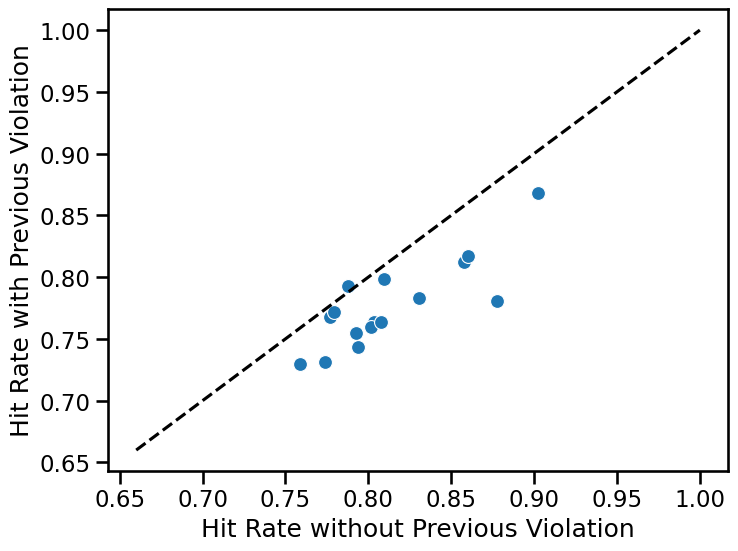

In [23]:
limits = (0.66, 1)
# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=wide_hit_rates, x="hit_rate_no_prev_viol", y="hit_rate_with_prev_viol", s=100
)

plt.plot(limits, limits, "k--", label="Unity Line")

plt.xlabel("Hit Rate without Previous Violation")
plt.ylabel("Hit Rate with Previous Violation")

plt.show()

Similar to what I saw in previous modeling results (but more extreme with this new dataset), hit rates immediately after a violation are lowers than those without. This suggests the interaction term will be important again.

## Trials Not Started

This was previously marked as a violation trial in the public dataset. It is when 200 s elapses and the animal does not engage with the center port. The "trial" elapses and a new trial is given. These trials were dropped from the data frame, but the column `n_prev_trial_not_started` indicated how many previous contiguous trials were not started. These trials

<Axes: xlabel='n_prev_trial_not_started', ylabel='Percent'>

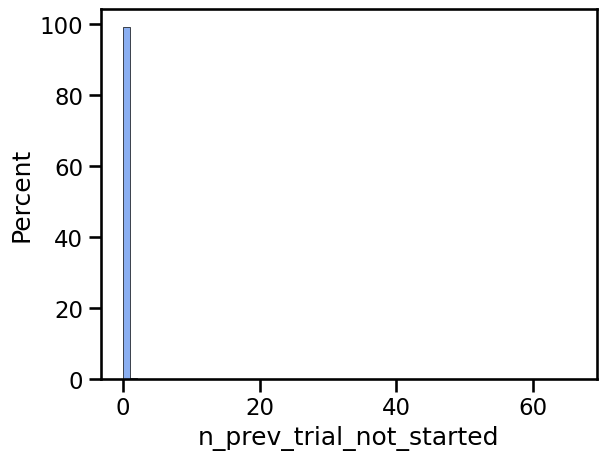

In [32]:
sns.histplot(
    data=trained_df,
    x="n_prev_trial_not_started",
    stat="percent",
    color="cornflowerblue",
    binwidth=1,
)

These trials are very rare- over 96% of the time they do not occur. Let's filter the 0s out and see what the distribution looks like.

<Axes: xlabel='n_prev_trial_not_started', ylabel='Percent'>

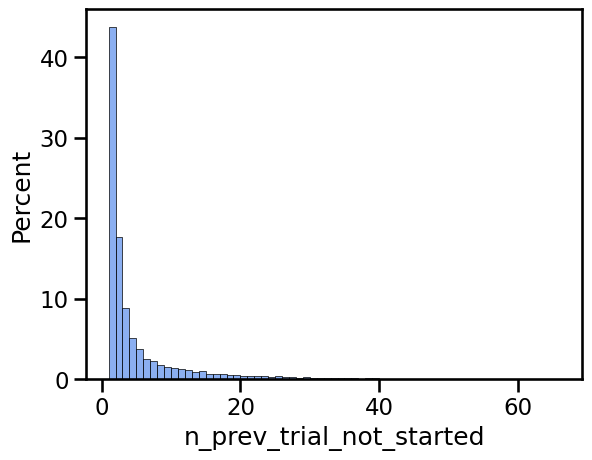

In [33]:
sns.histplot(
    data=trained_df.query("n_prev_trial_not_started != 0"),
    x="n_prev_trial_not_started",
    stat="percent",
    color="cornflowerblue",
    binwidth=1,
)

Okay great- in general they happen once, and then the distribution quickly decays after that. Let's see if this differs across animals.

<Axes: xlabel='n_prev_trial_not_started', ylabel='Percent'>

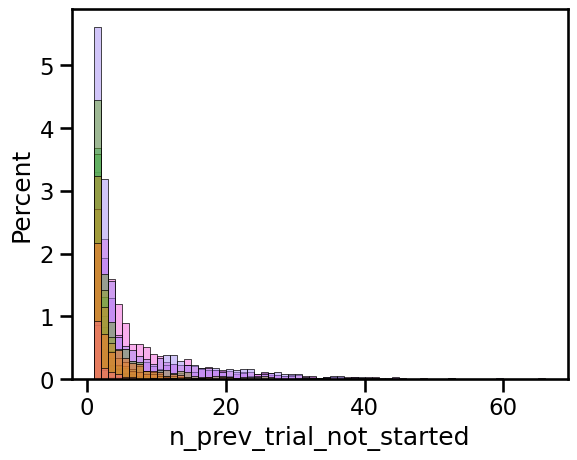

In [34]:
sns.histplot(
    data=trained_df.query("n_prev_trial_not_started != 0"),
    x="n_prev_trial_not_started",
    stat="percent",
    hue="animal_id",
    binwidth=1,
    legend=False,
)

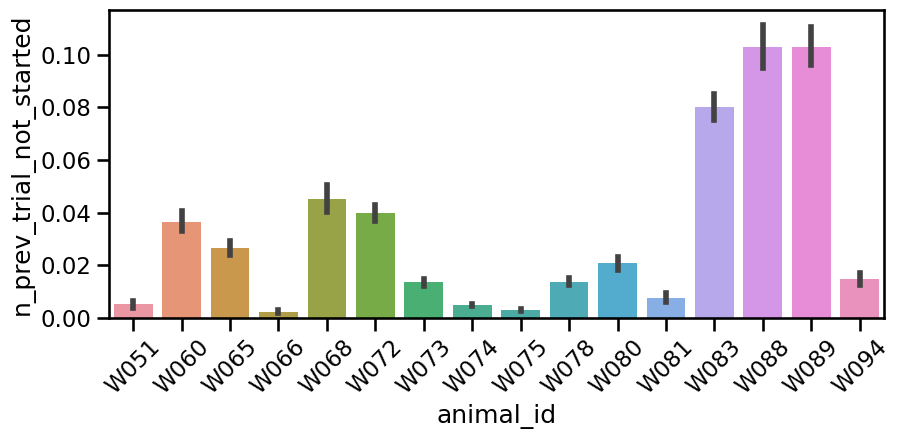

In [35]:
fig, ax = plt.subplots(figsize=(10, 4))

sns.barplot(data=trained_df, x="animal_id", y="n_prev_trial_not_started", ax=ax)

for a in ax.get_xticklabels():
    a.set_rotation(45)

Some animals do seem to have higher rates than others, but still, the rates are very, very low. Now, I want to make a df with the mean values for each animal to store out and compare with respect to hit rates and violation rates.

In [36]:
trained_df["prev_not_started"] = (trained_df["n_prev_trial_not_started"] != 0).astype(
    int
)

trained_not_started_rates = (
    trained_df.groupby(["animal_id", "session"])
    .prev_not_started.mean()
    .reset_index()
    .groupby("animal_id")
    .prev_not_started.mean()
    .reset_index()
)

trained_not_started_rates.rename(
    columns={"prev_not_started": "trained_prev_not_started"}, inplace=True
)

trained_not_started_rates.head()

trained_not_started_rates.to_csv(
    "../data/processed/from_eda/01_trained_prev_not_started_rates.csv", index=False
)

In [37]:
merged_results = pd.merge(
    trained_hit_viol_rates, trained_not_started_rates, on="animal_id"
)

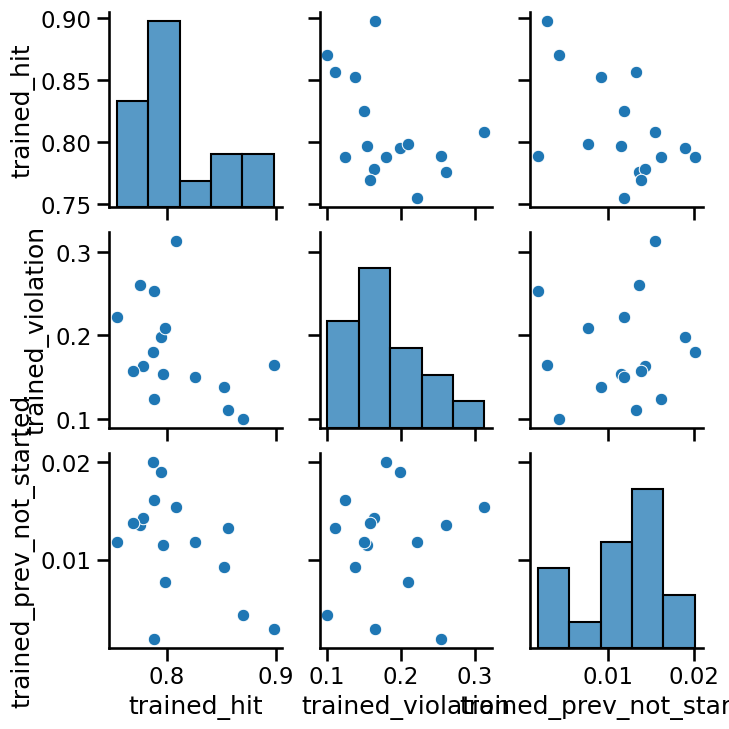

In [38]:
sns.pairplot(merged_results)

<Axes: >

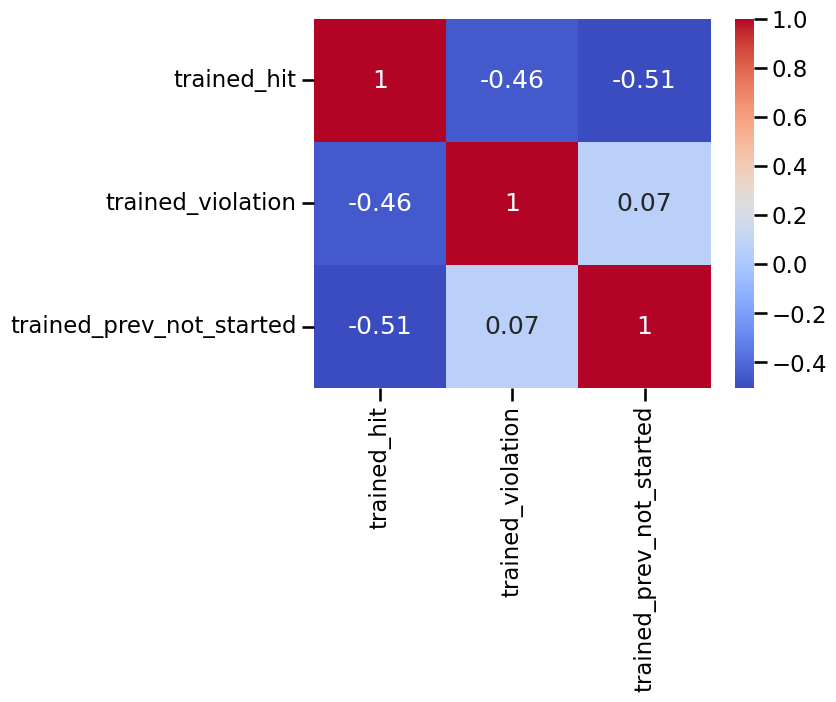

In [39]:
corr_results = merged_results.drop(columns=["animal_id"]).corr()

sns.heatmap(corr_results, annot=True, cmap="coolwarm")

It appears that n previous trial not started rates are negatively correlated with trained hit rates and positively correlated with violation rates.

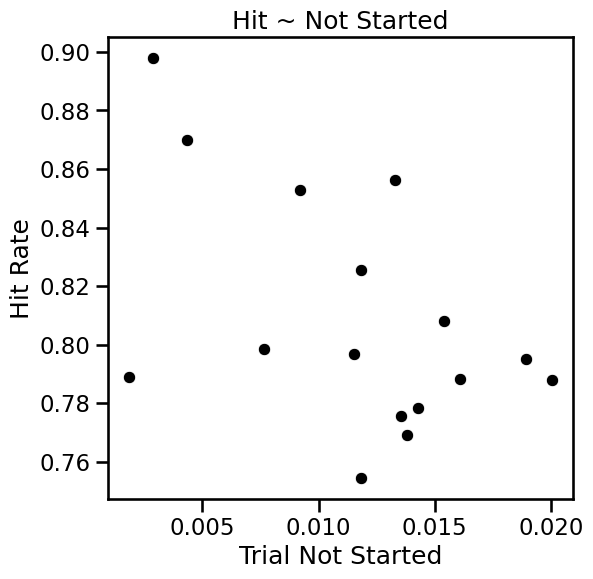

In [40]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    data=merged_results,
    y="trained_hit",
    x="trained_prev_not_started",
    color="k",
    ax=ax,
)

_ = ax.set(
    ylabel="Hit Rate",
    xlabel="Trial Not Started",
    title="Hit ~ Not Started",
)

Negative correlation between hit rates and trial not started- this is decently strong, although the trial not started values are so small.

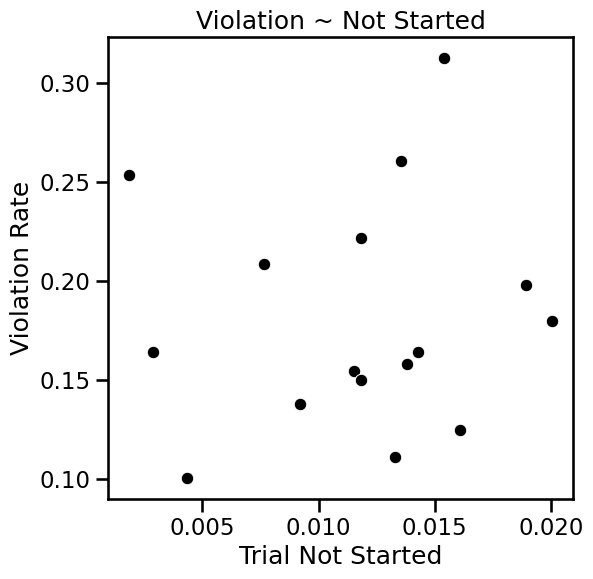

In [41]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    data=merged_results,
    y="trained_violation",
    x="trained_prev_not_started",
    color="k",
    ax=ax,
)

_ = ax.set(
    ylabel="Violation Rate",
    xlabel="Trial Not Started",
    title="Violation ~ Not Started",
)

No specific correlation between violation rates and trial not started rates. It appears to be positive due to the outliers. Now I want to create a column called "prev_disengaged". This means that the trial either had a previous violation or previous trial not started (irrespective of the amount). I want to see if hit rates differ here any more than just the previous violation hit rates. Given the low frequency of trials not started, I am not sure there will be a large effect.

In [42]:
def determine_disengaged(row):
    if row["n_prev_trial_not_started"] == 1 or row["prev_violation"] == 1:
        return 1
    else:
        return 0


trained_df["prev_disengaged"] = trained_df.apply(determine_disengaged, axis=1)

In [43]:
disengaged_hit_rates = (
    trained_df.groupby(["animal_id", "session", "prev_disengaged"])
    .hit.mean()
    .reset_index()
    .groupby(["animal_id", "prev_disengaged"])
    .hit.mean()
    .reset_index()
    .rename({"hit": "hit_rate"}, axis=1)
)

disengaged_hit_rates.head()

,animal_id,prev_disengaged,hit_rate
0,W051,0,0.803522
1,W051,1,0.763732
2,W060,0,0.830889
3,W060,1,0.782249
4,W065,0,0.777099


In [44]:
# Step 3: Turn long form -> Wide Form to plot each column
wide_hit_rates = disengaged_hit_rates.pivot(
    index="animal_id", columns="prev_disengaged", values="hit_rate"
)

wide_hit_rates.columns = ["hit_rate_prev_engaged", "hit_rate_prev_disengaged"]

wide_hit_rates.reset_index(inplace=True)

wide_hit_rates.to_csv(
    "../data/processed/from_eda/01_post_disengaged_hit_rates.csv", index=False
)
wide_hit_rates.head()

,animal_id,hit_rate_prev_engaged,hit_rate_prev_disengaged
0,W051,0.803522,0.763732
1,W060,0.830889,0.782249
2,W065,0.777099,0.767236
3,W066,0.787902,0.792891
4,W068,0.779461,0.771098


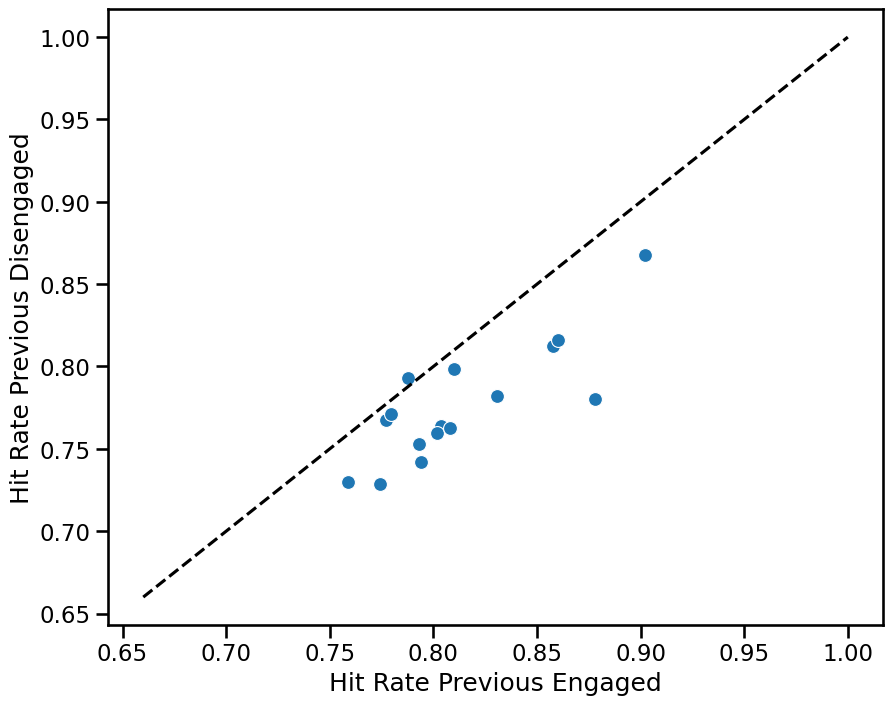

In [45]:
limits = (0.66, 1)
# Scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=wide_hit_rates, x="hit_rate_prev_engaged", y="hit_rate_prev_disengaged", s=100
)

plt.plot(limits, limits, "k--", label="Unity Line")

plt.xlabel("Hit Rate Previous Engaged")
plt.ylabel("Hit Rate Previous Disengaged")

plt.show()

This doesn't seem to change the plot very much from the previous violation one- same trend still holds. Likely due to the fact that the number of trial not started is quite low.

## Number of Delays


In [46]:
# get unique delay values for each animal
delay_stats = (
    full_df.query("training_stage > 3")
    .groupby("animal_id")
    .delay_time.unique()
    .reset_index()
)

# get the number of unique delay values for each animal
delay_stats["n_unique_delays"] = delay_stats.delay_time.apply(lambda x: len(x))
delay_stats["avg_delay_time"] = delay_stats.animal_id.map(
    full_df.query("training_stage > 3").groupby("animal_id").delay_time.mean()
)

delay_stats.to_csv("../data/processed/from_eda/01_delay_stats.csv", index=False)
delay_stats.head()

,animal_id,delay_time,n_unique_delays,avg_delay_time
0,W051,"[2.0, 4.0, 3.0, 6.0, 5.0]",5,3.396924
1,W060,"[2.0, 3.0, 4.0, 6.0]",4,3.133262
2,W065,"[3.0, 2.0, 4.0, 6.0]",4,3.700947
3,W066,"[3.0, 2.0, 4.0, 6.0, 5.0, 8.0, 7.0]",7,4.349539
4,W068,"[3.0, 2.0, 4.0, 6.0]",4,3.438329


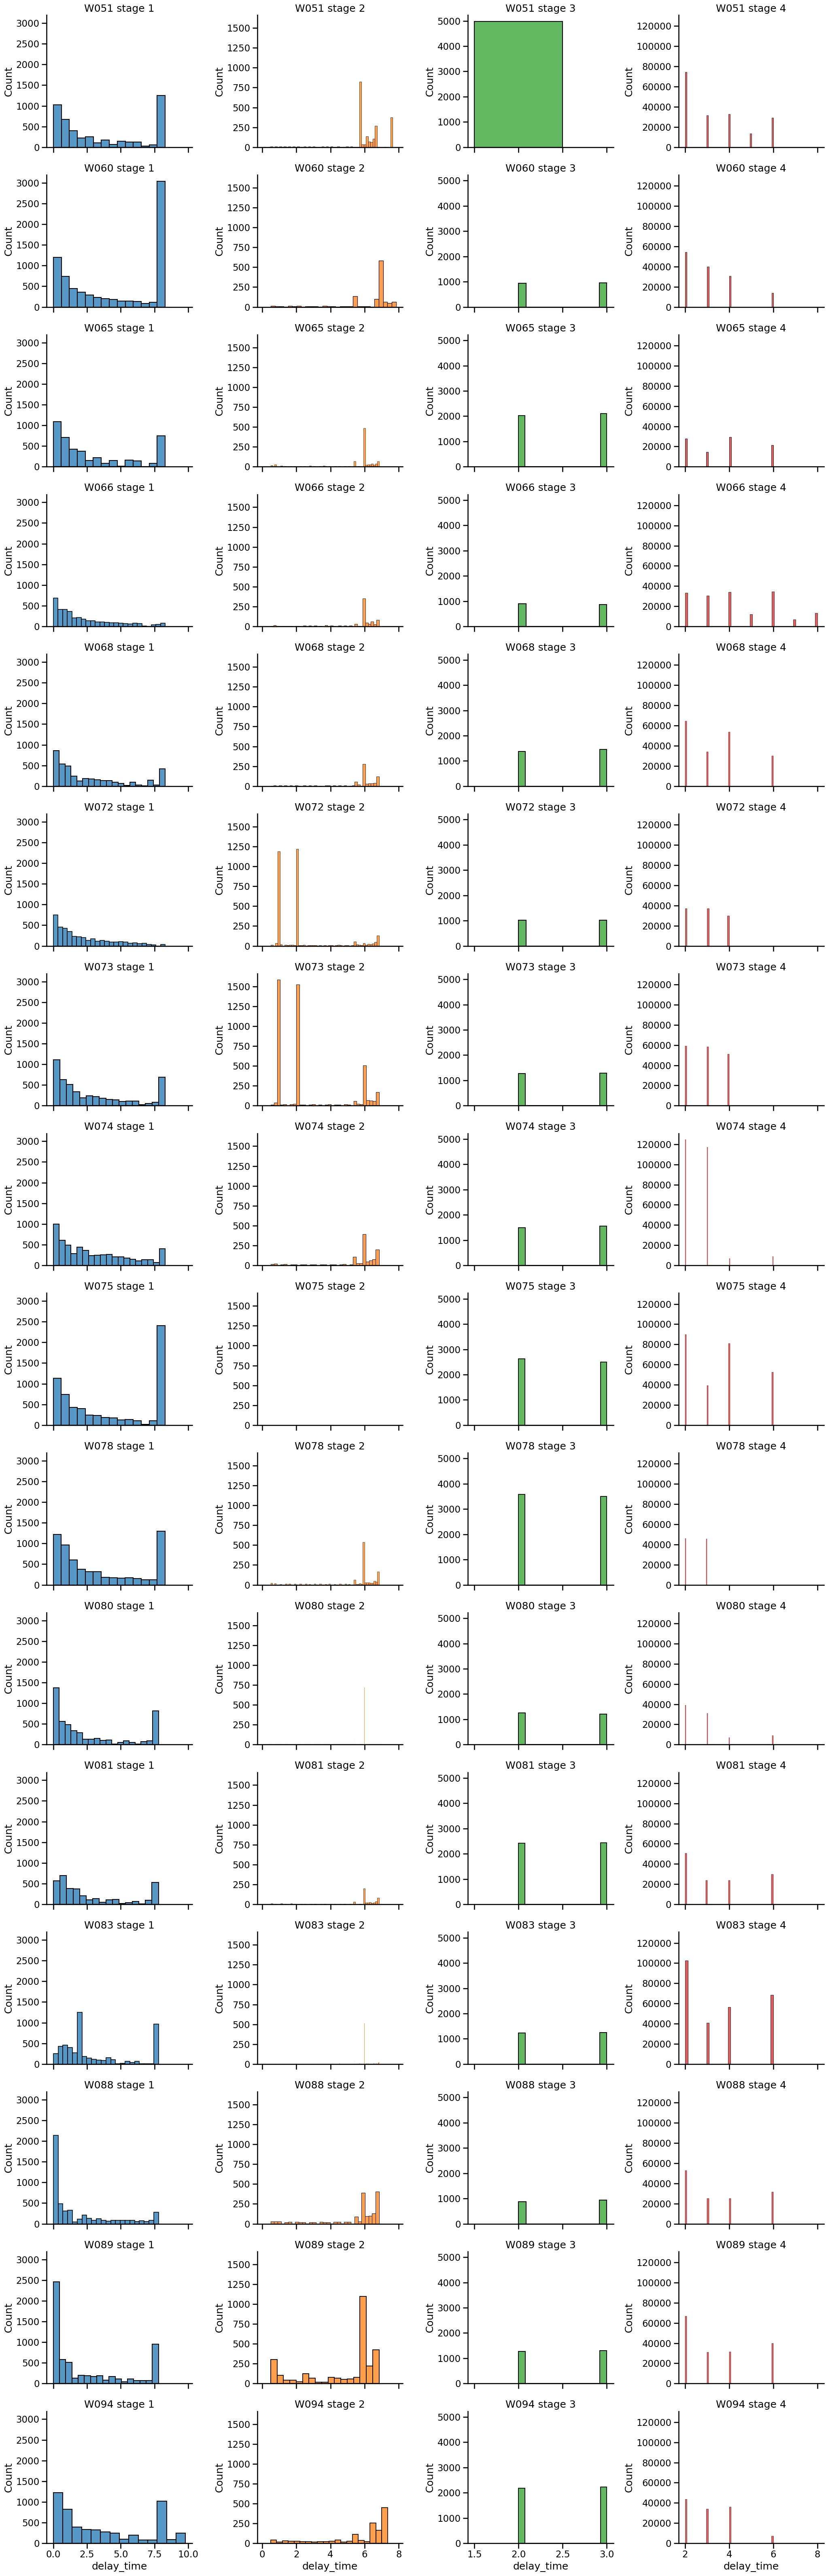

In [47]:
g = sns.FacetGrid(
    data=full_df,
    row="animal_id",
    col="training_stage",
    hue="training_stage",
    sharey="col",
    sharex="col",
    height=4,
    aspect=1.3,
)
g.map(sns.histplot, "delay_time")
g.set_titles("{row_name} stage {col_name}")

It appears that most of the delay variation comes from stage 1 and 2 during gnp. However, in stage 4 there is a quite a bit of variation in delay lengths for each animal.

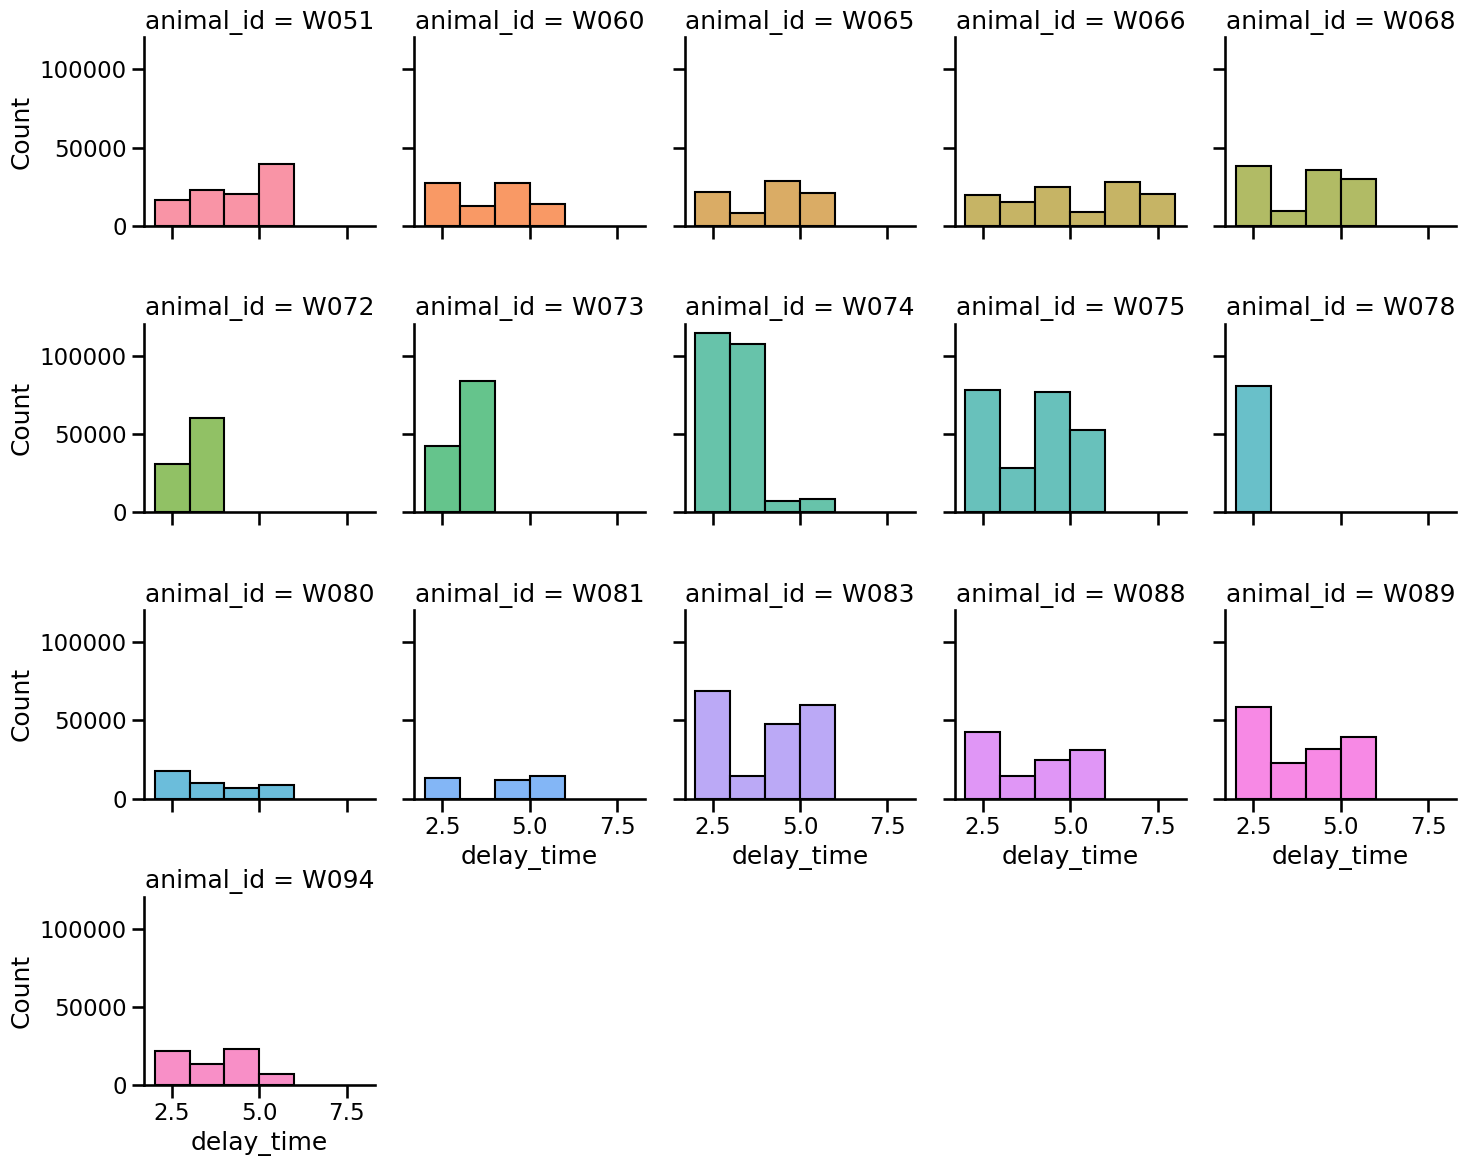

In [48]:
g = sns.FacetGrid(
    data=trained_df,
    col="animal_id",
    hue="animal_id",
    col_wrap=5,
)
g.map(sns.histplot, "delay_time", binwidth=1)

## Performance ~ Delay

### Hits

[Text(0.5, 1.0, 'Stage 3+ Hit Rates ~ Delay'), (0.0, 1.0)]

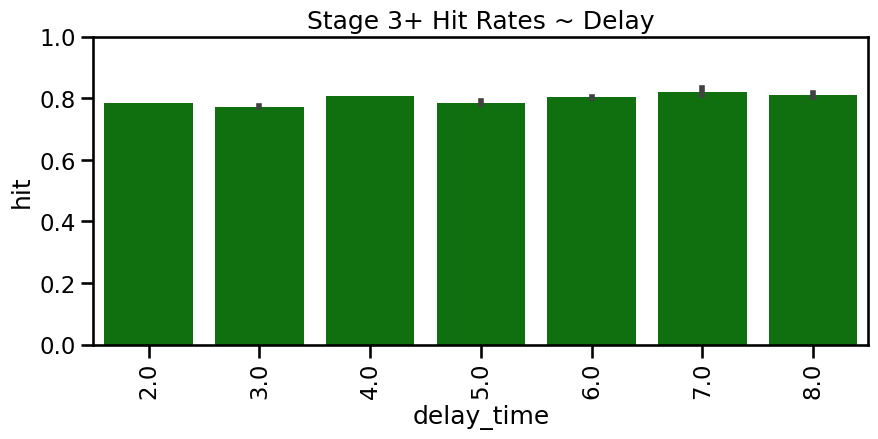

In [49]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(
    data=full_df.query("training_stage >=  3"),
    x="delay_time",
    y="hit",
    color="green",
    ax=ax,
)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(title="Stage 3+ Hit Rates ~ Delay", ylim=(0, 1))

[Text(0.5, 1.0, 'Trained Hit Rates ~ Delay'), (0.0, 1.0)]

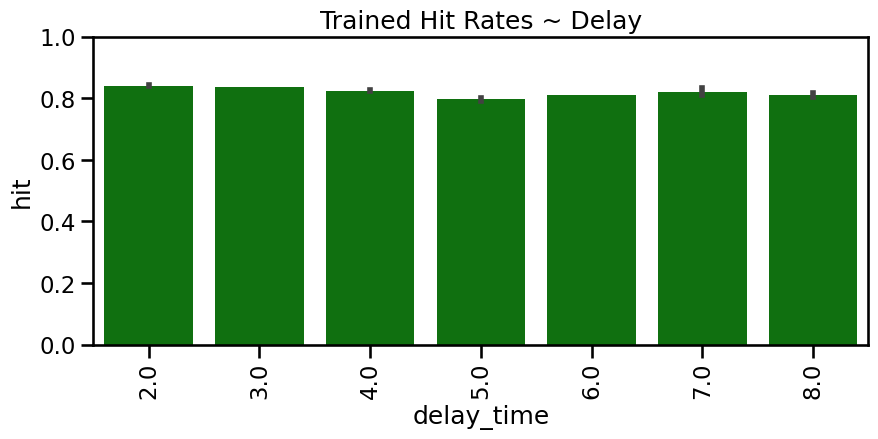

In [50]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.barplot(
    data=trained_df,
    x="delay_time",
    y="hit",
    color="green",
    ax=ax,
)
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set(title="Trained Hit Rates ~ Delay", ylim=(0, 1))

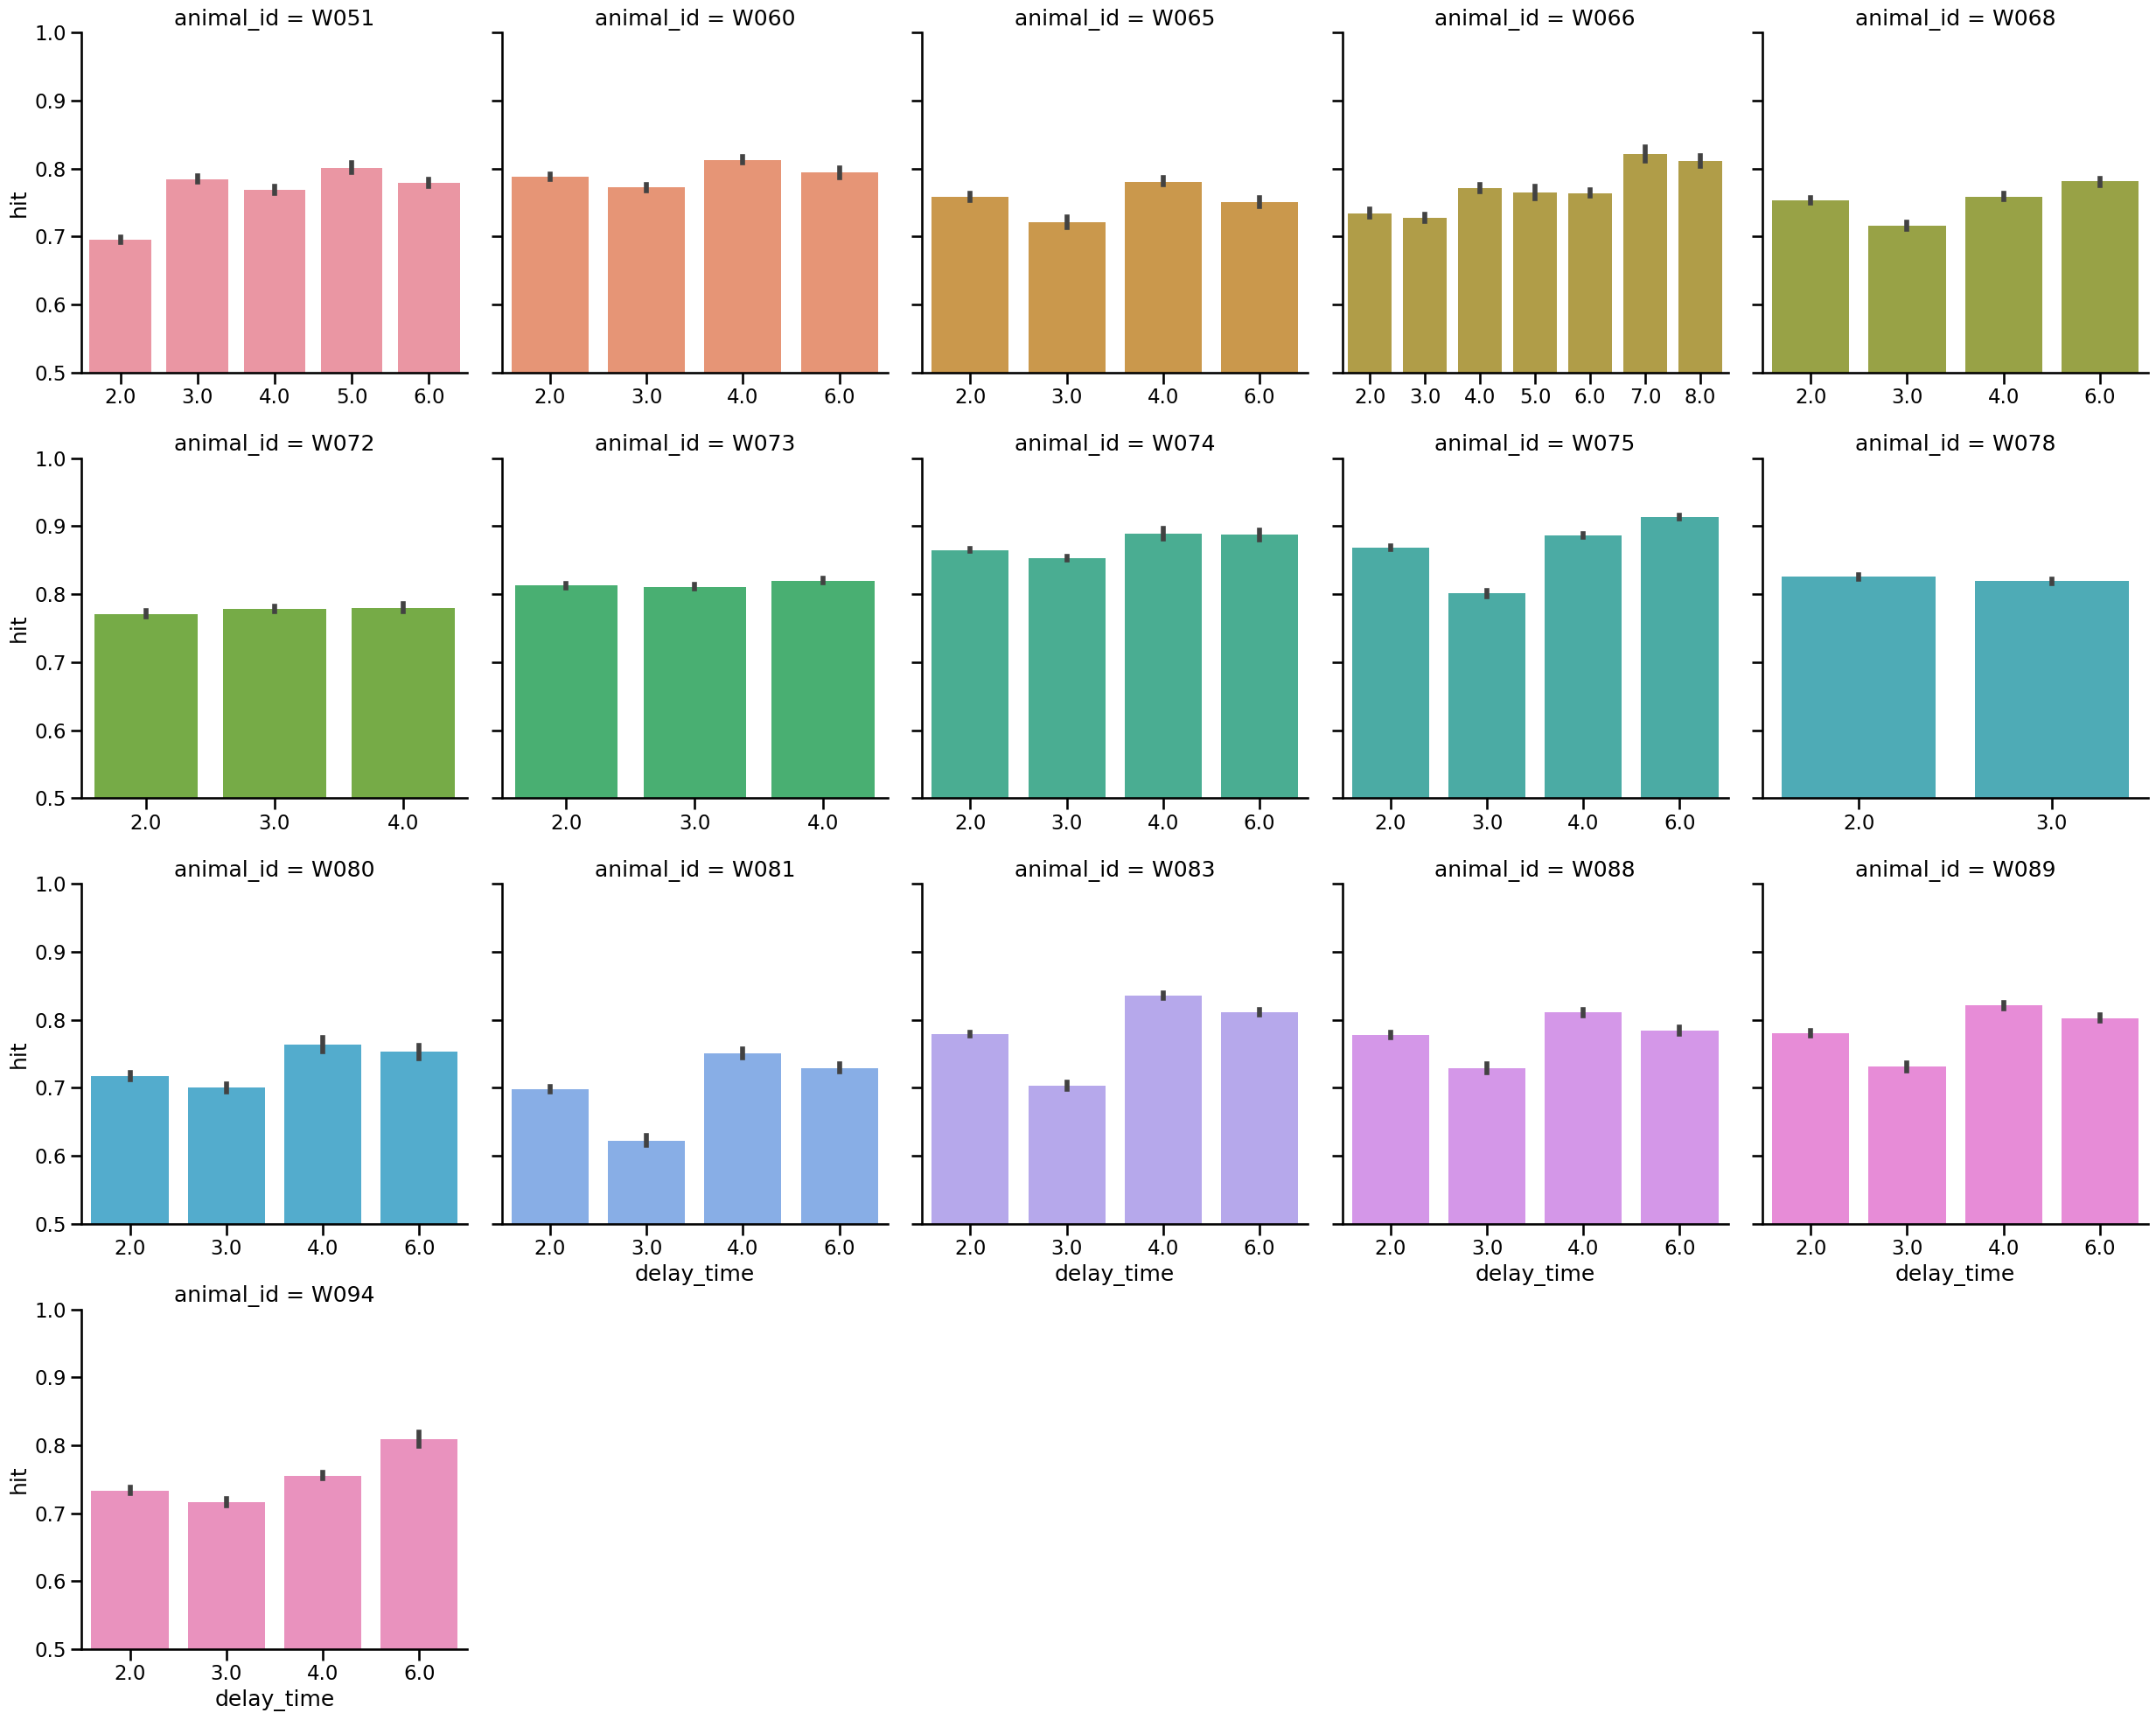

In [51]:
g = sns.catplot(
    x="delay_time",
    y="hit",
    col="animal_id",
    col_wrap=5,
    hue="animal_id",
    data=full_df.query("training_stage >=  3"),
    kind="bar",
    dodge=False,
    sharey=True,
    sharex=False,
)

g.set(ylim=(0.5, 1))

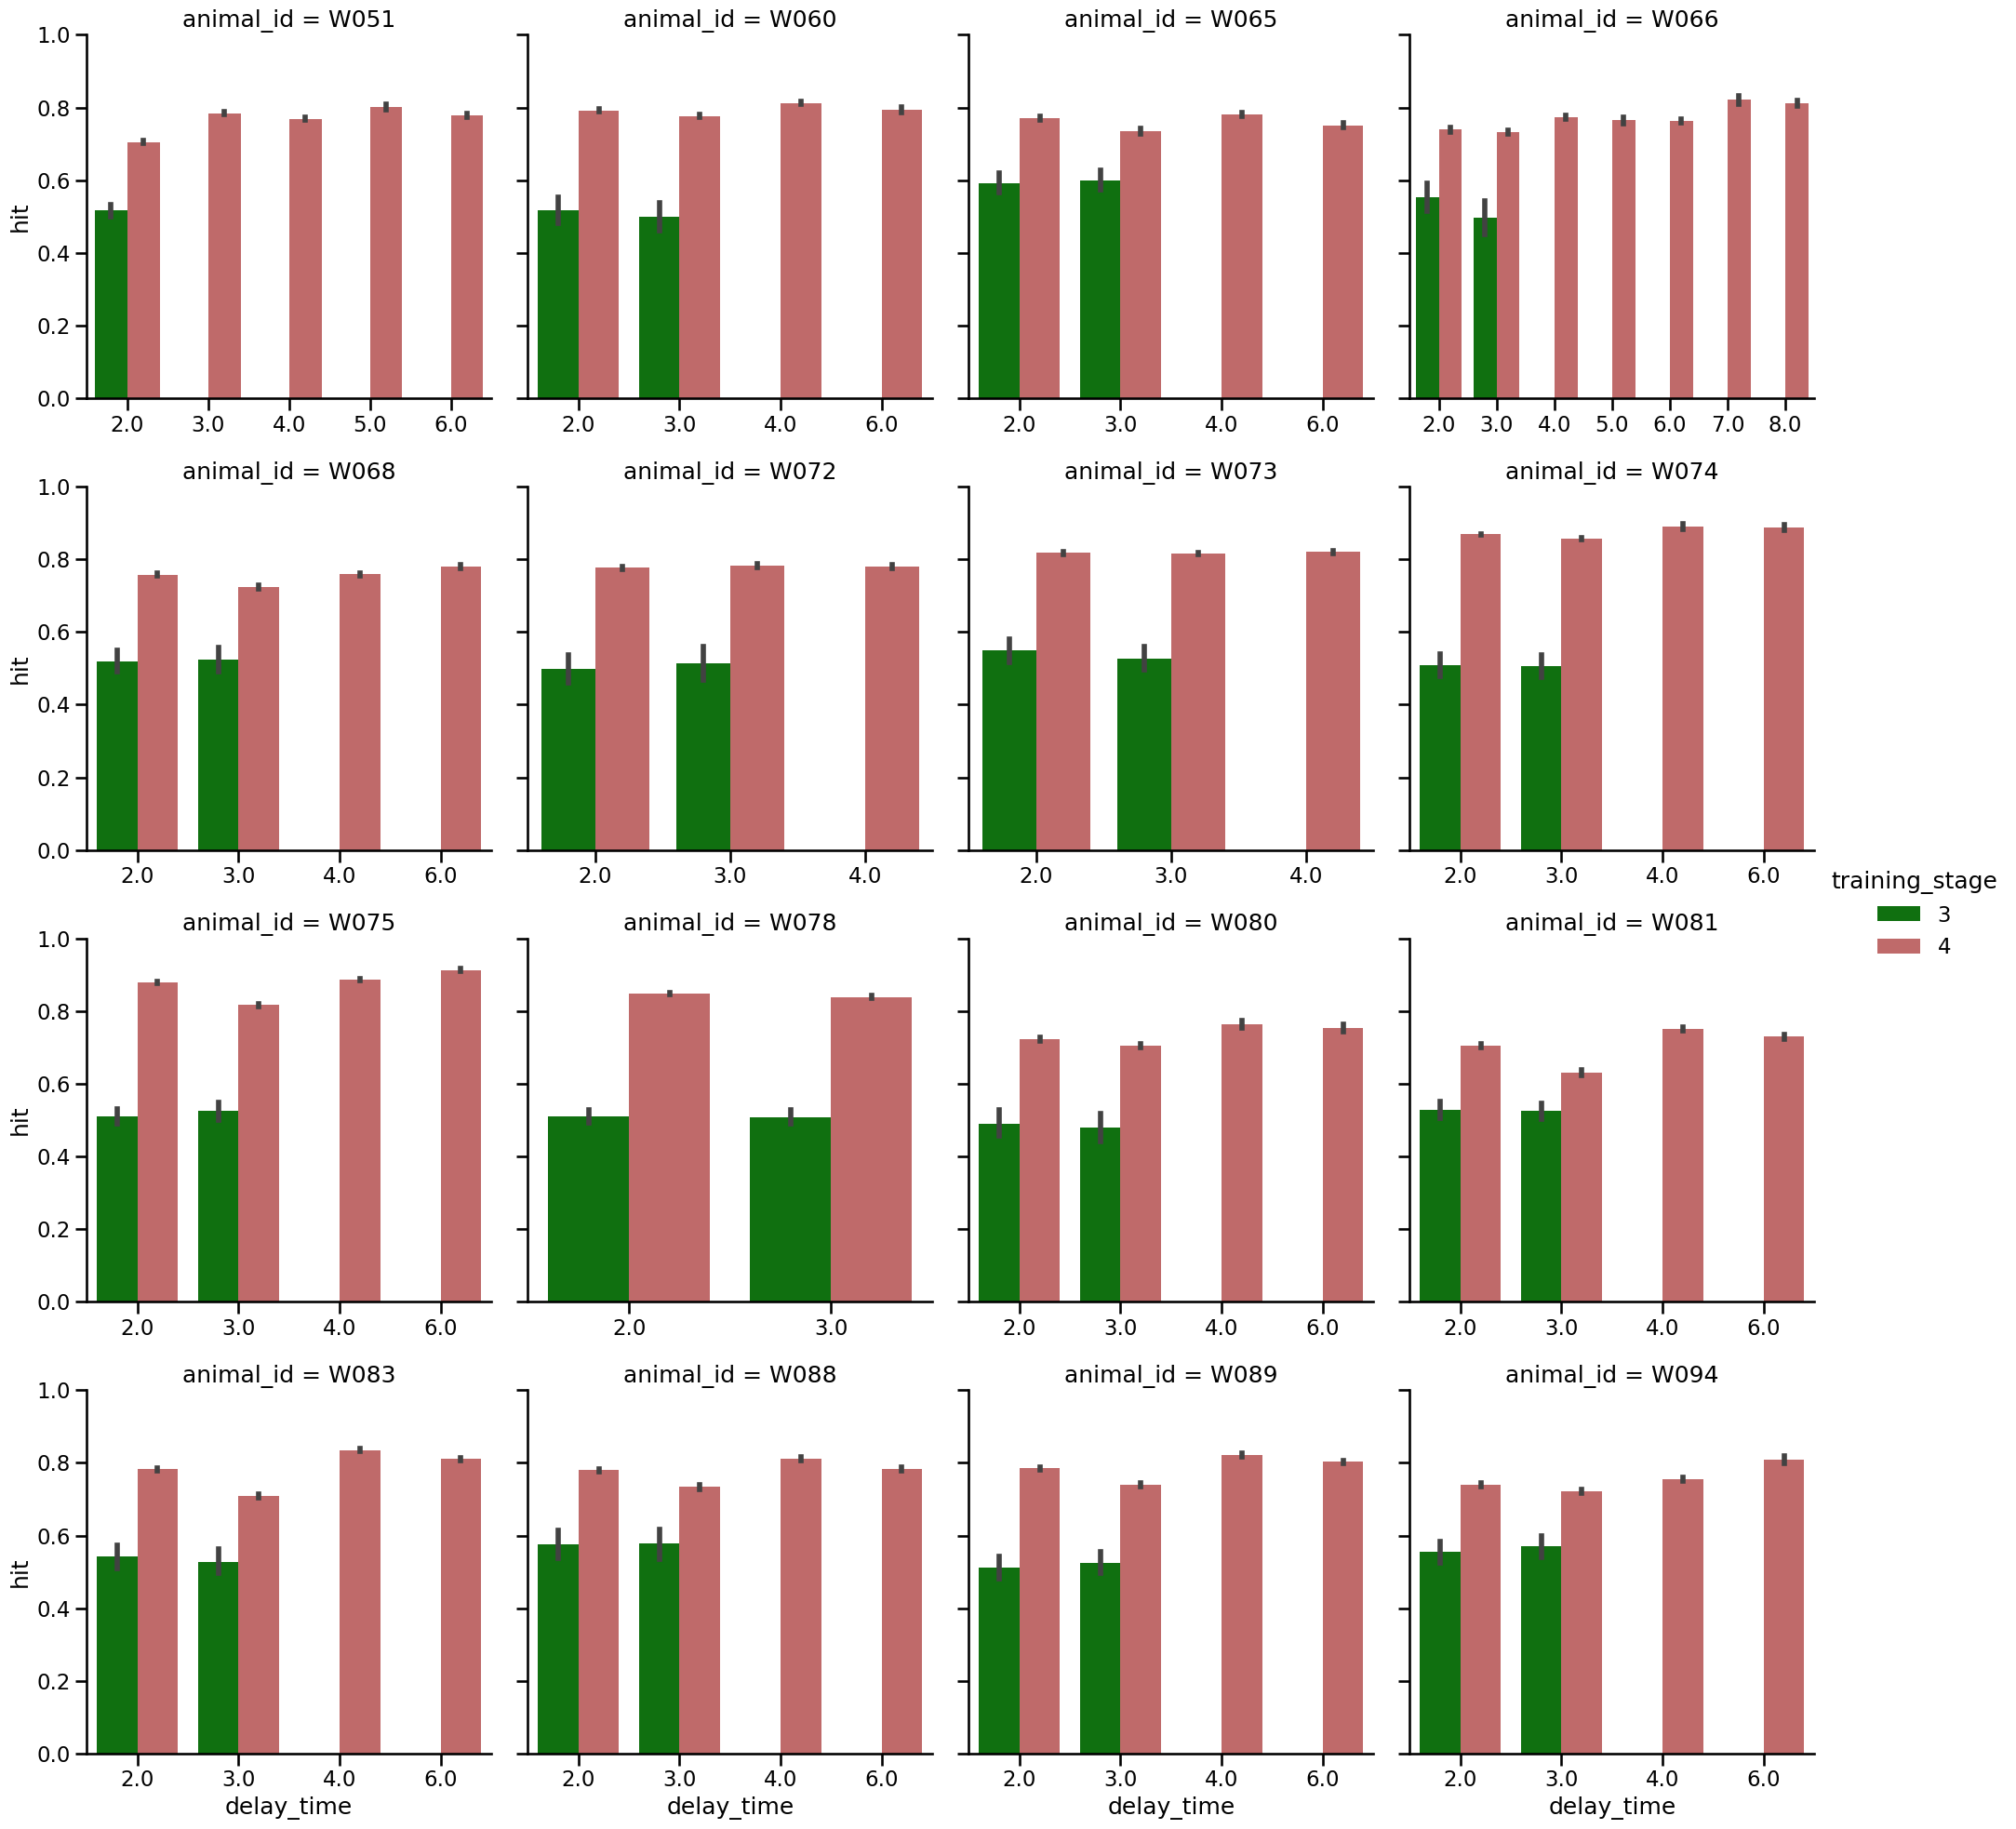

In [52]:
g = sns.catplot(
    x="delay_time",
    y="hit",
    col="animal_id",
    col_wrap=4,
    hue="training_stage",
    data=full_df.query("training_stage >=  3"),
    kind="bar",
    palette=["green", "indianred"],
    dodge=True,
    sharey=True,
    sharex=False,
)

g.set(ylim=(0, 1))

### Violations

<Axes: xlabel='delay_time'>

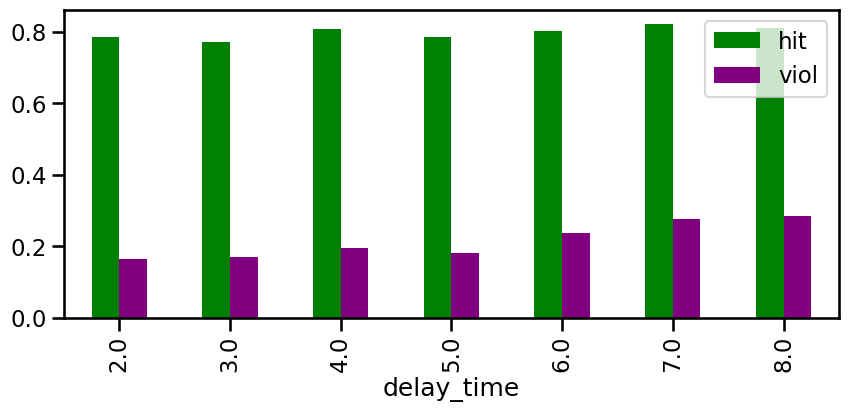

In [53]:
discrete_delay_df = (
    full_df.query("training_stage >=  3")
    .groupby(["delay_time"])
    .hit.mean()
    .reset_index()
)
discrete_delay_df["viol"] = (
    full_df.query("training_stage >=  3")
    .groupby(["delay_time"])
    .violation.mean()
    .values
)
discrete_delay_df.plot(
    kind="bar",
    x="delay_time",
    y=["hit", "viol"],
    color=["green", "purple"],
    figsize=(10, 4),
)

My hypothesis would have been that the longer the delay, the lower the violation rate and hte higher the hit rate. However, these plots suggest this is not the case.